In [0]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time
from sklearn.metrics import mean_squared_error as MSE
import statsmodels.api as sm
import scipy
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import *
import copy
from sklearn.metrics import *
import os
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 7.1 Treatment effect

(all that can do inference) PLMNN, DML(Lasso),DML(RF),PLM NW(vanilla),OLS,pure NN

test MSE, train MSE, betahat,betahat SD

## Data preprocessing

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_stata('/content/drive/My Drive/DPLM/sipp1991.dta')
Variables = ["inc", 'e401', "age", "educ", "fsize", "marr", "twoearn", "db", "pira", "hown"]
# Variables = ['e401', "age", "inc", "educ", "fsize", "marr", "twoearn", "db", "pira", "hown"]

In [0]:
data.head()

,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
0,0.0,0.0,4500.0,47,6765.0,2,8,0,0,0,0,0,0,1
1,6215.0,1015.0,22390.0,36,28452.0,1,16,0,0,0,0,0,0,1
2,0.0,-2000.0,-2000.0,37,3300.0,6,12,1,0,0,0,0,0,0
3,15000.0,15000.0,155000.0,58,52590.0,2,16,0,1,1,0,0,0,1
4,0.0,0.0,58000.0,32,21804.0,1,11,0,0,0,0,0,0,1


In [0]:
y = data.net_tfa.values.reshape(-1, 1)
tempp = data[Variables]
X = tempp.values
ymax=np.max(y);ymin=np.min(y)
# factor=1e4;y=y/factor
# y = MinMaxScaler().fit_transform(y)

In [0]:
X.shape

(9915, 10)

## PLMNN, NW, Lasso, Regression tree, Random forest

### models

In [0]:
"""The :mod:`sklearn.kernel_regressor` module implements the Kernel Regressor.
"""
# Author: Jan Hendrik Metzen <janmetzen@mailbox.de>
#
# License: BSD 3 clause

import numpy as np

from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin


class KernelRegression(BaseEstimator, RegressorMixin):
    """Nadaraya-Watson kernel regression with automatic bandwidth selection.

    This implements Nadaraya-Watson kernel regression with (optional) automatic
    bandwith selection of the kernel via leave-one-out cross-validation. Kernel
    regression is a simple non-parametric kernelized technique for learning
    a non-linear relationship between input variable(s) and a target variable.

    Parameters
    ----------
    kernel : string or callable, default="rbf"
        Kernel map to be approximated. A callable should accept two arguments
        and the keyword arguments passed to this object as kernel_params, and
        should return a floating point number.

    gamma : float, default=None
        Gamma parameter for the RBF ("bandwidth"), polynomial,
        exponential chi2 and sigmoid kernels. Interpretation of the default
        value is left to the kernel; see the documentation for
        sklearn.metrics.pairwise. Ignored by other kernels. If a sequence of
        values is given, one of these values is selected which minimizes
        the mean-squared-error of leave-one-out cross-validation.

    See also
    --------

    sklearn.metrics.pairwise.kernel_metrics : List of built-in kernels.
    """

    def __init__(self, kernel="rbf", gamma=None):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        """Fit the model

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The training input samples.

        y : array-like, shape = [n_samples, m]
            The target values

        Returns
        -------
        self : object
            Returns self.
        """
        self.X = X
        self.y = y

        if hasattr(self.gamma, "__iter__"):
            self.gamma = self._optimize_gamma(self.gamma)

        return self

    def predict(self, X_test):
        """Predict target values for X_test, size m*n_features.

        Parameters
        ----------
        X_test : array-like of shape = [n_te_samples, n_features]
            The input samples.

        Returns
        -------
        y : array of shape = [n_te_samples, m]
            The predicted target value.
        """
        K = pairwise_kernels(self.X, X_test, metric=self.kernel, gamma=self.gamma)
        # K.shape=[n_tr_samples, n_te_samples]
        # self.X.shape=[n_tr_samples, n_features]
        # self.y.shape=[n_tr_samples, m]
        if self.y.ndim==1:
            ncol=1
        else:
            ncol=self.y.shape[1]
        numerator=(np.transpose(self.y).dot(K)).reshape(ncol,K.shape[1])
        return np.transpose(numerator / K.sum(axis=0))

    def _optimize_gamma(self, gamma_values):
        # Select specific value of gamma from the range of given gamma_values
        # by minimizing mean-squared error in leave-one-out cross validation
        mse = np.empty_like(gamma_values, dtype=np.float)
        for i, gamma in enumerate(gamma_values):
            K = pairwise_kernels(self.X, self.X, metric=self.kernel,
                                 gamma=gamma)
            np.fill_diagonal(K, 0)  # leave-one-out
            Ky = K * self.y[:, np.newaxis]
            y_pred = Ky.sum(axis=0) / K.sum(axis=0)
            mse[i] = ((y_pred - self.y) ** 2).mean()

        return gamma_values[np.nanargmin(mse)]

In [0]:
def newset(y, Z, T):
  new_y = torch.tensor(np.concatenate((y, Z), axis=1)).float()
  new_data = torch.tensor(T).float()
  return new_y, new_data

In [0]:
def PLMNN(y_train, Z_train, T_train, y_test, Z_test, T_test):

  D_in, H, D_out = T_train.shape[1], 10000, Z_train.shape[1]+1
  max_epoch, lr, batch_size = 20, 1e-5, 256

  yZ_train, T_train = newset(y_train, Z_train, T_train)
  yZ_test, T_test = newset(y_test, Z_test, T_test)

  new_T_train, new_T_val, new_yZ_train, new_yZ_val = \
  train_test_split(T_train, yZ_train, test_size=0.2, random_state=42)

  Train_dataset = TensorDataset(new_T_train, new_yZ_train)
  trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)
  Test_dataset = TensorDataset(new_T_val, new_yZ_val)
  testloader = DataLoader(dataset=Test_dataset, batch_size=1, shuffle=False)


  model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=2)
  criterion = nn.MSELoss()
  old_val_error=1e12
  patience=0

  for epoch in range(max_epoch):
    for batch_T, batch_yZ in trainloader:
      optimizer.zero_grad()
      batch_yZ_pred = model(batch_T)
      batch_loss = criterion(batch_yZ_pred, batch_yZ)
      batch_loss.backward()
      optimizer.step()
    with torch.no_grad():
      yZ_pred = model(new_T_val)
      val_loss = criterion(yZ_pred, new_yZ_val)
      # print(epoch, val_loss)

    #early stopping
    if val_loss.item()<old_val_error:
      old_val_error=val_loss.item()
      patience=0
    else:
      patience+=1
    if patience == 1:
      print('break at epoch:', epoch)
      break
    
  model.eval()
  ml_pred_ytrain, ml_pred_Ztrain = \
  model(T_train)[:, 0].detach().numpy(), model(T_train)[:, 1:].detach().numpy()
  ml_pred_ytest, ml_pred_Ztest = \
  model(T_test)[:, 0].detach().numpy(), model(T_test)[:, 1:].detach().numpy()
  return ml_pred_ytrain.reshape(-1,1), ml_pred_Ztrain, ml_pred_ytest.reshape(-1,1), ml_pred_Ztest

### Partial out

In [0]:
def PatialOut(y_train, Z_train, T_train, y_test, Z_test, T_test, ml):
  if ml == 'PLMNN':
    ml_pred_ytrain, ml_pred_Ztrain, ml_pred_ytest, ml_pred_Ztest = \
    PLMNN(y_train, Z_train, T_train, y_test, Z_test, T_test)

  else: 
    if ml == 'Kernel':
      ml_y = KernelRegression() 
      ml_Z = KernelRegression() 

    elif ml == 'Lasso':
      ml_y = Lasso(alpha = 1, max_iter=1e4) 
      ml_Z = Lasso(alpha = 1, max_iter=1e4) 

    elif ml == 'Regression tree':
      ml_y = DecisionTreeRegressor(max_depth=2)
      ml_Z = DecisionTreeRegressor(max_depth=2) 

    elif ml == 'Random forest':
      ml_y = RandomForestRegressor(max_depth=2)
      ml_Z = RandomForestRegressor(max_depth=2) 

    else:
      print('Wrong ML name!')

    ml_y.fit(T_train, y_train)
    ml_Z.fit(T_train, Z_train)
    ml_pred_ytrain = ml_y.predict(T_train).reshape(-1,1)
    ml_pred_ytest = ml_y.predict(T_test).reshape(-1,1)
    # print(ml_pred_ytest)
    ml_pred_Ztrain = ml_Z.predict(T_train).reshape(-1,1)
    ml_pred_Ztest = ml_Z.predict(T_test).reshape(-1,1)

    ### remove nan rows for kernel regression
    na_index=np.isnan(ml_pred_ytest*ml_pred_Ztest)
    y_test = y_test[~na_index].reshape(-1,1)
    ml_pred_ytest = ml_pred_ytest[~na_index].reshape(-1,1)
    Z_test = Z_test[~na_index].reshape(-1,1)
    ml_pred_Ztest = ml_pred_Ztest[~na_index].reshape(-1,1)

  # OLS
  ols_train = LinearRegression(fit_intercept=False).\
  fit(Z_train-ml_pred_Ztrain, y_train-ml_pred_ytrain)
  # beta = ols_train.coef_
  ytrain_pred = ols_train.predict(Z_train-ml_pred_Ztrain) + ml_pred_ytrain
  ytrain_mse = np.mean((ytrain_pred-y_train)**2) 
  # print(ml, Z_test.shape, ml_pred_Ztest.shape, y_test.shape, ml_pred_ytest.shape)

  ols_test = LinearRegression(fit_intercept=False).\
  fit(Z_test-ml_pred_Ztest, y_test-ml_pred_ytest)
  beta = ols_test.coef_
  ytest_pred = ols_test.predict(Z_test-ml_pred_Ztest) + ml_pred_ytest
  ytest_mse = np.mean((ytest_pred-y_test)**2)
  # print(ytrain_mse.shape, beta.shape)
  return ytrain_mse, ytest_mse, beta

### Run

In [0]:
import warnings
warnings.filterwarnings("ignore")

kfold = 10
torch.manual_seed(1)
kf = KFold(n_splits=kfold)
count = 0
ytrain_mse_plm, ytest_mse_plm, beta_plm = np.zeros(kfold), np.zeros(kfold), np.zeros(kfold)
ytrain_mse_nw, ytest_mse_nw, beta_nw = np.zeros(kfold), np.zeros(kfold), np.zeros(kfold)
ytrain_mse_lasso, ytest_mse_lasso, beta_lasso = np.zeros(kfold), np.zeros(kfold), np.zeros(kfold)
ytrain_mse_rt, ytest_mse_rt, beta_rt = np.zeros(kfold), np.zeros(kfold), np.zeros(kfold)
ytrain_mse_rf, ytest_mse_rf, beta_rf = np.zeros(kfold), np.zeros(kfold), np.zeros(kfold)
beta_ols=np.zeros(kfold)

for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  Z_train, T_train = X_train[:, 0].reshape((-1,1)), X_train[:, 1:]
  Z_test, T_test = X_test[:, 0].reshape((-1,1)),  X_test[:, 1:]
  
  # OLS

  # PLMNN
  ytrain_mse_plm[count], ytest_mse_plm[count], beta_plm[count] = \
  PatialOut(y_train, Z_train, T_train, y_test, Z_test, T_test, ml='PLMNN')

  # Kernel regression
  ytrain_mse_nw[count], ytest_mse_nw[count], beta_nw[count] = \
  PatialOut(y_train, Z_train, T_train, y_test, Z_test, T_test, ml='Kernel')

  # Lasso
  ytrain_mse_lasso[count], ytest_mse_lasso[count], beta_lasso[count] = \
  PatialOut(y_train, Z_train, T_train, y_test, Z_test, T_test, ml='Lasso')


  # Regression tree
  ytrain_mse_rt[count], ytest_mse_rt[count], beta_rt[count] = \
  PatialOut(y_train, Z_train, T_train, y_test, Z_test, T_test, ml='Regression tree')

  # Random forest
  ytrain_mse_rf[count], ytest_mse_rf[count], beta_rf[count] = \
  PatialOut(y_train, Z_train, T_train, y_test, Z_test, T_test, ml='Random forest')
  
  count += 1

### Results

In [0]:
print(np.mean(beta_plm),np.median(beta_plm), np.std(beta_plm))

0.5908993929624557 0.5969221889972687 0.18650778460626732


In [0]:
print(np.mean(beta_nw),np.median(beta_nw), np.std(beta_nw))

0.9121383309364319 0.9318813383579254 0.3513529386816794


In [0]:
print(np.mean(beta_lasso),np.median(beta_lasso), np.std(beta_lasso))

0.8879226535558701 0.9111838936805725 0.41592935033775524


In [0]:
print(np.mean(beta_rt),np.median(beta_rt), np.std(beta_rt))

0.805973433378685 0.8041305485237005 0.38551140281672236


In [0]:
print(np.mean(beta_rf),np.median(beta_rf), np.std(beta_rf))

0.8099061044261481 0.8103805138120654 0.38879054020987985


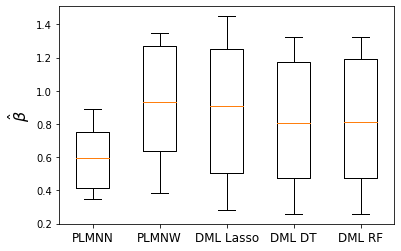

In [0]:
plt.boxplot([beta_plm,beta_nw,beta_lasso,beta_rt,beta_rf])
plt.xticks(range(1,6),['PLMNN','PLMNW','DML Lasso','DML DT','DML RF'],fontsize=12)
plt.ylabel(r'$\hat\beta$',fontsize=16)
plt.savefig('treatment.pdf');plt.show()

# 7.2 Adversarial attack

## Data preprocessing

In [0]:
import pandas as pd
# df = pd.read_csv('/content/drive/My Drive/DPLM/German_credit.csv')
# df = pd.read_csv('/content/drive/My Drive/DPLM/UCI_Credit_Card.csv')
df = pd.read_csv('/content/drive/My Drive/DPLM/UCI_Credit_Card 2.csv')
df.keys()

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [0]:
df=df.rename(columns = {'default.payment.next.month':'default'})
print(df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [0]:
df.MARRIAGE=df.MARRIAGE.map({2:2,1:1,3:3,0:np.nan})
df['EDUCATION']=df.EDUCATION.map({1:1,2:2,3:3,4:4,0:np.nan,5:np.nan,6:np.nan})
# df.isnull().sum()

## Marriage
df1 = df[np.isfinite(df['MARRIAGE'])]
df2=df[df['MARRIAGE'].isnull()==True]
y1=df1.MARRIAGE
df1=df1.drop('MARRIAGE',axis=1)
df2=df2.drop('MARRIAGE',axis=1)
df1=df1[['AGE','SEX','PAY_0','PAY_2','PAY_3']]
df2=df2[['AGE','SEX','PAY_0','PAY_2','PAY_3']]
clf = LogisticRegression(max_iter = 10000)
clf.fit(df1,y1)
y_pred=clf.predict(df2)
df2['MARRIAGE']=y_pred
df1['MARRIAGE']=y1
df1=df1[['MARRIAGE']]
df2=df2[['MARRIAGE']]
B=pd.concat([df1,df2])
B.sort_index(inplace=True)
df.MARRIAGE=B

In [0]:
## Education
df1 = df[np.isfinite(df['EDUCATION'])]
df2=df[df['EDUCATION'].isnull()==True]
y1=df1.EDUCATION
df1=df1.drop('EDUCATION',axis=1)
df2=df2.drop('EDUCATION',axis=1)
df1=df1[['AGE','SEX','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5']]
df2=df2[['AGE','SEX','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5']]
clf = LogisticRegression(max_iter = 10000)
clf.fit(df1,y1)
y_pred=clf.predict(df2)
df2['EDUCATION']=y_pred
df1['EDUCATION']=y1
df1=df1[['EDUCATION']]
df2=df2[['EDUCATION']]
B=pd.concat([df1,df2])
B.sort_index(inplace=True)
df.EDUCATION=B

In [0]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.817000,1.554500,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.708892,0.518239,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [0]:
# df.drop(['Encode1', 'Encode2', 'LogPay'],axis=1,inplace=True)
df.drop('ID',axis=1,inplace=True)

# df['PayBill1']=df['BILL_AMT1']*df['PAY_0']
# df['PayBill2']=df['BILL_AMT2']*df['PAY_2']
# df['PayBill3']=df['BILL_AMT3']*df['PAY_3']
# df['PayBill4']=df['BILL_AMT4']*df['PAY_4']
# df['PayBill5']=df['BILL_AMT5']*df['PAY_5']
# df['PayBill6']=df['BILL_AMT6']*df['PAY_6']

# df['PayPay1']=df['PAY_AMT1']*df['PAY_0']
# df['PayPay2']=df['PAY_AMT2']*df['PAY_2']
# df['PayPay3']=df['PAY_AMT3']*df['PAY_3']
# df['PayPay4']=df['PAY_AMT4']*df['PAY_4']
# df['PayPay5']=df['PAY_AMT5']*df['PAY_5']
# df['PayPay6']=df['PAY_AMT6']*df['PAY_6']

df.SEX=df.SEX.map({1:'male',2:'female'})
df.EDUCATION=df.EDUCATION.map({1:'graduate school',2:'University',3:'High School',4:'Others'})
df.MARRIAGE=df.MARRIAGE.map({1:'married',2:'single',3:'others'})

def encode_onehot(df, cols):
    vec = DictVectorizer()
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict('records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(cols, axis=1)
    df = df.join(vec_data)
    return df
X = encode_onehot(df, cols=['SEX'])
X1 =encode_onehot(X, cols=['EDUCATION'])
X2 =encode_onehot(X1, cols=['MARRIAGE'])
X2.columns

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default', 'SEX=female', 'SEX=male',
       'EDUCATION=High School', 'EDUCATION=Others', 'EDUCATION=University',
       'EDUCATION=graduate school', 'MARRIAGE=married', 'MARRIAGE=others',
       'MARRIAGE=single'],
      dtype='object')

In [0]:
X2.keys()

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default', 'SEX=female', 'SEX=male',
       'EDUCATION=High School', 'EDUCATION=Others', 'EDUCATION=University',
       'EDUCATION=graduate school', 'MARRIAGE=married', 'MARRIAGE=others',
       'MARRIAGE=single'],
      dtype='object')

In [0]:
# X = df.iloc[:,1:].values
# y = df.iloc[:,0].values
# X = StandardScaler().fit_transform(X)

In [0]:
# X = df.iloc[:,1:-1].values
# y = df.iloc[:,-1].values
# X = df.iloc[:,1:].values
# y = df.iloc[:,0].values
X1 = X2.drop(['default'],axis=1)
X1[['SEX=female','SEX=male',
       'EDUCATION=High School', 'EDUCATION=Others', 'EDUCATION=University',
       'EDUCATION=graduate school', 'MARRIAGE=married', 'MARRIAGE=others',
       'MARRIAGE=single']].replace(0,-1,inplace=True)
X1 = X1.values
y = df.default.values
# X=X1.copy()
X = StandardScaler().fit_transform(X1)
# y=y[:100];X=X[:100,:]

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [0]:
X2.columns

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default', 'SEX=female', 'SEX=male',
       'EDUCATION=High School', 'EDUCATION=Others', 'EDUCATION=University',
       'EDUCATION=graduate school', 'MARRIAGE=married', 'MARRIAGE=others',
       'MARRIAGE=single'],
      dtype='object')

In [0]:
X.shape

(30000, 29)

## Setting

In [0]:
def newset(y, Z, T):
  y = y.reshape((-1, 1))
  new_y = torch.tensor(np.concatenate((y, Z), axis=1)).float()
  new_data = torch.tensor(T).float()
  return new_y, new_data

In [0]:
# Nrun,split_size,sigma,n,p,p1,alpha,verbose, n_splits=50,0.2,1,70000,31,1,0.05,0,2

## MLP (Baseline)
No attack pure MLP baseline

In [0]:
max_epoch = 50
lr = 1e-4 #5e-6 for german
D_in, H1, D_out = X.shape[1], 200, 1 #p1_new will be selected by lasso later
# print(D_in, D_out)
batch_size = 512

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test = torch.tensor(X_train).float(), torch.tensor(X_test).float()
y_train, y_test = torch.tensor(y_train).reshape((-1,1)).float(), \
torch.tensor(y_test).reshape((-1,1)).float()

Train_dataset = TensorDataset(X_train, y_train)
trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)
Test_dataset = TensorDataset(X_test, y_test)
testloader = DataLoader(dataset=Test_dataset, batch_size=batch_size, shuffle=False)

torch.manual_seed(0)

MLP = nn.Sequential(
    nn.Linear(D_in, H1),
    nn.ReLU(),
    nn.Linear(H1, H1),
    nn.ReLU(),
    nn.Linear(H1, D_out),
    # nn.Sigmoid()
)

optimizer = torch.optim.Adam(MLP.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()
old_val_error=1e12
patience=0

for epoch in range(max_epoch):
    for batch_X, batch_y in trainloader:
        optimizer.zero_grad()
        batch_y_pred = MLP(batch_X)
        batch_loss = criterion(batch_y_pred, batch_y)
        batch_loss.backward()
        optimizer.step()
    with torch.no_grad(): 
      # for batch_T_test, batch_yZ_test in testloader:
      val_y_test = MLP(X_test)
      val_loss = criterion(val_y_test, y_test)
      val_acc = np.mean((val_y_test.cpu().detach().numpy()>0)==y_test.numpy())
      print(epoch+1, 'val loss', val_loss, 'val accuracy', val_acc)
    #early stopping
      if val_loss.item()<old_val_error:
          old_val_error=val_loss.item()
          patience=0
      else:
          patience+=1  
      if patience == 2:
          print('break at epoch', epoch)
          break

1 val loss tensor(0.5548) val accuracy 0.7838333333333334
2 val loss tensor(0.5137) val accuracy 0.7838333333333334
3 val loss tensor(0.4940) val accuracy 0.8003333333333333
4 val loss tensor(0.4808) val accuracy 0.807
5 val loss tensor(0.4710) val accuracy 0.8103333333333333
6 val loss tensor(0.4634) val accuracy 0.8138333333333333
7 val loss tensor(0.4580) val accuracy 0.816
8 val loss tensor(0.4531) val accuracy 0.8148333333333333
9 val loss tensor(0.4503) val accuracy 0.8183333333333334
10 val loss tensor(0.4476) val accuracy 0.8153333333333334
11 val loss tensor(0.4455) val accuracy 0.817
12 val loss tensor(0.4437) val accuracy 0.82
13 val loss tensor(0.4425) val accuracy 0.8163333333333334
14 val loss tensor(0.4409) val accuracy 0.8198333333333333
15 val loss tensor(0.4402) val accuracy 0.8215
16 val loss tensor(0.4388) val accuracy 0.8208333333333333
17 val loss tensor(0.4376) val accuracy 0.8203333333333334
18 val loss tensor(0.4364) val accuracy 0.8205
19 val loss tensor(0.435

## DPLM



No attack pure MLP baseline, OLS,DebiNet (forward-backward, Lasso, Elastic Net, two-level SLOPE, adaptive lasso) attack MLP with different number of layers

In [0]:
def PLM(X_train, X_test, y_train, y_test, coef):
  new_p1 = sum(coef!=0)
  Z_train = X_train[:, coef!=0]
  T_train = X_train[:, coef==0]
  Z_test = X_test[:, coef!=0]
  T_test = X_test[:, coef==0]
  #LASSO+PLM
  yZ_train, T_train = newset(y_train, Z_train, T_train)
  yZ_test, T_test = newset(y_test, Z_test, T_test)
  # print(yZ_train.shape, T_train.shape)

  max_epoch = 1000
  lr = 1e-4
  D_in, H, D_out = X.shape[1]-new_p1, 500, new_p1+1 #p1_new will be selected by lasso later
  # print(D_in, D_out)
  batch_size = 1024

  Train_dataset = TensorDataset(T_train, yZ_train)
  trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)
  Test_dataset = TensorDataset(T_test, yZ_test)
  testloader = DataLoader(dataset=Test_dataset, batch_size=batch_size, shuffle=False)

  model = nn.Sequential(
      nn.Linear(D_in, H),
      nn.ReLU(),
      nn.Linear(H, D_out),
  )

  optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=2)
  criterion = nn.MSELoss()
  old_val_error=1e12
  patience=0

  for epoch in range(max_epoch):
    for batch_T, batch_yZ in trainloader:
      optimizer.zero_grad()
      batch_yZ_pred = model(batch_T)
      batch_loss = criterion(batch_yZ_pred, batch_yZ)

      batch_loss.backward()
      optimizer.step()
    with torch.no_grad(): 
      val_yZ_test = model(T_test)
      val_loss = criterion(val_yZ_test, yZ_test)
      val_acc = np.mean((val_yZ_test.cpu().detach().numpy()>0)==yZ_test.numpy())
      # print(epoch+1, 'val loss', val_loss, 'val accuracy', val_acc)
      if val_loss.item()<old_val_error:
          old_val_error=val_loss.item()
          patience=0
      else:
          patience+=1  
      if patience == 2:
          break
  print('training with', epoch, 'steps')
  whole_pred=model(T_train).detach().numpy()
  mean_conditional_y=whole_pred[:,0]
  mean_conditional_Z=whole_pred[:,1:]
  whole_pred_te=model(T_test).detach().numpy()
  mean_conditional_y_te=whole_pred_te[:,0]
  mean_conditional_Z_te=whole_pred_te[:,1:]
  PLM_ols = LinearRegression(fit_intercept = False).fit(Z_train-mean_conditional_Z, y_train.reshape(-1,1)-mean_conditional_y.reshape(-1,1))
  temp=coef.copy()
  temp[coef!=0]=PLM_ols.coef_[0]

  return temp

In [0]:
def simulations(X, y, split_size=0.2, lasso_alpha=2, elas_alpha=1, l1_ratio=0.5, verbose=0):
  beta_ols, beta_plm_lasso, beta_plm_elas, beta_plm_lars=[],[],[],[]
  torch.manual_seed(0)
  np.random.seed(0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=42)

  # LASSO
  lasso = Lasso(alpha = lasso_alpha, fit_intercept=False) # lasso: alpha=1 prediction bad; alpha=0.1 no zero; mixture 0.15
  lasso.fit(X_train, y_train)
  lasso_coef=lasso.coef_
  print('LASSO selects ',sum(lasso_coef!=0),' variables out of ', X.shape[1])


  # Elastic Net
  elas = ElasticNet(alpha = elas_alpha, l1_ratio=l1_ratio, fit_intercept=False)
  elas.fit(X_train, y_train)
  elas_coef=elas.coef_
  print('Elastic net selects ',sum(elas_coef!=0),' variables out of ', X.shape[1])


  # Lars
  lars = Lars(n_nonzero_coefs=10, fit_intercept=False) # , 
  lars.fit(X_train, y_train)
  lars_coef=lars.coef_
  print('Lars selects ',sum(lars_coef!=0),' variables out of ', X.shape[1])


  # OLS if low dimension
  ols = LinearRegression(fit_intercept=False).fit(X_train, y_train)
  beta_ols.append(ols.coef_)
  # y_ols.append(ols.predict(X_train))
  # y_ols_te.append(ols.predict(X_test))
  # print(MSE(ols.predict(X_test),y_test.flatten()))
  print('acc of ols', np.mean(abs(ols.predict(X_test)-y_test.flatten())<0.5))

  temp_lasso = PLM(X_train, X_test, y_train, y_test, lasso_coef)
  beta_plm_lasso.append(temp_lasso)

  temp_elas = PLM(X_train, X_test, y_train, y_test, elas_coef)
  beta_plm_elas.append(temp_elas)

  temp_lars = PLM(X_train, X_test, y_train, y_test, lars_coef)
  beta_plm_lars.append(temp_lars)
  # y_plm.append(mean_conditional_y.flatten()+(Z_train-mean_conditional_Z).dot((PLM_ols.coef_).reshape(-1)))
  # y_plm_te.append(mean_conditional_y_te.flatten()+(Z_test-mean_conditional_Z_te).dot((PLM_ols.coef_).reshape(-1)))


  # if verbose==1:
  #   #Output
  #   print('LASSO selects ',sum(lasso_coef!=0),' variables out of ', X.shape[1])
  #   print('Lasso: ', lasso_coef[lasso_coef!=0]) #lasso
  #   print('DebiNet: ', PLM_ols.coef_)# lasso+PLM

  return ([beta_ols, beta_plm_lasso, beta_plm_elas, beta_plm_lars,[lasso_coef],[elas_coef]])

## Attack & Results

In [0]:
def attack(result, mode):
  print('MLP(Baseline)')
  MLP.eval()
  val_y_test = MLP(X_test)
  val_loss = criterion(val_y_test, y_test)
  print('val loss', val_loss)
  print('accuracy',np.mean((val_y_test.cpu().detach().numpy()>0)==y_test.numpy()))
  print('AUC',roc_auc_score(y_test.numpy(),val_y_test.cpu().detach().numpy()))
  for i in range(len(result)):
    print('--------------------------------')
    print('PLM with variable selection method: ', mode[i])
    col_to_attack=np.argmax(np.abs(result[i]))
    print(col_to_attack, result[i][0].flatten()[col_to_attack])
    Xtest=X_test.cpu().detach().numpy()
    temp_min, temp_max = min(Xtest[:, col_to_attack]), max(Xtest[:, col_to_attack])
    # print(temp_min,temp_max)
    new_X_test = Xtest.copy()
    if result[i][0].flatten()[col_to_attack]>0:
      # print('Sign of coeficient: pos')
      new_X_test[y_test.numpy().flatten()==1,col_to_attack]=temp_min
      new_X_test[y_test.numpy().flatten()==0,col_to_attack]=temp_max
    else:
      # print('Sign of coeficient: neg')
      new_X_test[y_test.numpy().flatten()==1,col_to_attack]=temp_max
      new_X_test[y_test.numpy().flatten()==0,col_to_attack]=temp_min
    # print('Average difference:', np.mean(new_X_test-Xtest))

    val_y_test = MLP(torch.tensor(new_X_test))
    val_loss = criterion(val_y_test, y_test)
    print('val loss', val_loss)
    print('accuracy',np.mean((val_y_test.cpu().detach().numpy()>0)==y_test.numpy()))
    print('AUC',roc_auc_score(y_test.numpy(),val_y_test.cpu().detach().numpy()>0))
    print('Recall',recall_score(y_test.numpy(),val_y_test.cpu().detach().numpy()>0))
    print('F1 score',f1_score(y_test.numpy(),val_y_test.cpu().detach().numpy()>0))
    print('Precision',precision_score(y_test.numpy(),val_y_test.cpu().detach().numpy()>0))


In [0]:
result = simulations(X, y, lasso_alpha=0.01,elas_alpha=0.02) # 0.02
attack(result, mode = ['ols', 'lasso_PLM', 'elastic_PLM', 'Lars_PLM','Lasso','Elastic'])

LASSO selects  9  variables out of  29
Elastic net selects  11  variables out of  29
Lars selects  10  variables out of  29
Low dimension
acc of ols 0.781
training with 22 steps
training with 21 steps
training with 20 steps
MLP(Baseline)
val loss tensor(0.4282, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
accuracy 0.8236666666666667
AUC 0.771828903646043
--------------------------------
PLM with variable selection method:  ols
24 604014430879.992
val loss tensor(0.3946, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
accuracy 0.8395
AUC 0.6865509818287217
Recall 0.4171164225134927
F1 score 0.5290953545232274
Precision 0.42768447136336835
Precision 0.7232620320855615
--------------------------------
PLM with variable selection method:  lasso_PLM
2 0.1027046915131916
val loss tensor(3.9474, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
accuracy 0.007666666666666666
AUC 0.01605809117066471
Recall 0.03084040092521203
F1 score 0.01325820351342393
Precision 0.209760421371545
Precision 0

In [0]:
result[0]

[array([-1.13262653e-02,  1.17909768e-02,  1.06420580e-01,  2.65700866e-02,
         1.10613842e-02,  7.99071966e-03,  2.98622695e-03,  3.39648096e-03,
        -4.63214105e-02,  1.31788624e-02,  2.61750924e-03, -1.20683291e-02,
        -1.36021313e-03,  8.95980366e-03, -9.94911410e-03, -4.54067424e-03,
         1.78350626e-03, -2.82208869e-03, -2.95587609e-03, -3.10972902e-03,
         1.01865460e+09,  1.01865460e+09,  4.48026288e+11,  7.72797185e+10,
         6.04014431e+11,  5.78854747e+11,  5.22589118e+10,  1.08279943e+10,
         5.23458161e+10])]

In [0]:
result[4]

[array([-0.00888635,  0.00361456,  0.10268363,  0.02423038,  0.00880484,
         0.00610534,  0.        ,  0.        , -0.02475438, -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.00340103,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ,  0.        ,  0.        , -0.        , -0.        ,
         0.        ,  0.        ,  0.        , -0.0052299 ])]